In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import rioxarray as rxr
import os
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from scipy.stats import gaussian_kde
import seaborn as sns

In [2]:
# Load M1 design storm subset to montecito basins. 
out = r'/Volumes/PhD/imagery/masters/output/hyper_compare/'
m1_basins = gpd.read_file(r'/Volumes/PhD/imagery/masters/QGIS/M1_design_storm_subset.shp')
m1_basins = m1_basins.to_crs(epsg=32611)
print(m1_basins.crs)
#m1_basins
print(m1_basins.columns)

EPSG:32611
Index(['BASIN_ID', 'Shape_Leng', 'Shape_Area', 'Segment_ID', 'Acc_Cl',
       'Perim_Buff', 'InsidePeri', 'OutsidePer', 'Fire_ID', 'Fire_Segme',
       'L_X1', 'L_X2', 'L_X3', 'V_X1', 'V_X2', 'Shape_Le_1', 'R', 'V_X3', 'X',
       'ExpX', 'P', 'PCl', 'PCl_Legend', 'LnV', 'Volume', 'VolMin', 'VolMax',
       'VolCl', 'VolCl_Lege', 'CombHaz', 'CombHazCl', 'CombHazCl_',
       'Mean_dNBR', 'Med_dNBR', 'PF_dNBR', 'geometry'],
      dtype='object')


In [3]:
# Read in HdNBR & HdNBRI rasters.
# Naming convention is backwards, will be flipped in code (i.e., INPUT - idealized == S2 bands, OUTPUT - idealized == AVIRIS specific bands)


idealized_bands = r'/Volumes/PhD/imagery/masters/hyper/dnbr_aviris_warp.dat' 

S2_bands = r'/Volumes/PhD/imagery/masters/hyper/S2/AVIRIS_dNBR_idealized_t2'

#idealized_bands = rxr.open_rasterio(idealized_bands, masked=True)
idealized_bands = rxr.open_rasterio(idealized_bands, masked=True)
S2_bands = rxr.open_rasterio(S2_bands, masked=True)
#print(s.rio.crs)




In [4]:
# clip to basin, and add mean, med, PF to m1 basins.
basin_list = []
mean_list = []
median_list = []
peak_frequency_list = []
i_mean_list = []
i_median_list = []
i_peak_frequency_list = []

for idx, basin in m1_basins.iterrows():
    iclipped = idealized_bands.rio.clip([basin.geometry], idealized_bands.rio.crs, drop=True)
    clipped = S2_bands.rio.clip([basin.geometry], S2_bands.rio.crs, drop=True)

    # Gather basic stats & basin id
    
    basin_list.append(basin['BASIN_ID'])
    mean_value = np.nanmean(clipped)
    median_value = np.nanmedian(clipped)

    imean_value = np.nanmean(iclipped)
    imedian_value = np.nanmedian(iclipped)

    mean_list.append(mean_value)
    median_list.append(median_value)
    i_mean_list.append(imean_value)
    i_median_list.append(imedian_value)

    # Gather kde peak frequency for both clipped and iclipped
  
    x = clipped.values.flatten()
    x = x[~np.isnan(x)]  
    
    kde = gaussian_kde(x)  # Fit KDE to non-NaN values

    # Define a grid of values for evaluation
    x_grid = np.linspace(x.min(), x.max(), 1000)

    # Evaluate KDE on the grid
    kde_values = kde(x_grid)

    # Find the peak value
    peak_index = kde_values.argmax() 
    peak_frequency = x_grid[peak_index]

    y = iclipped.values.flatten()
    y = y[~np.isnan(y)]  # Remove NaN values
    
    ikde = gaussian_kde(y)  # Fit KDE to non-NaN values

    # Define a grid of values for evaluation
    y_grid = np.linspace(y.min(), y.max(), 1000)

    # Evaluate KDE on the grid
    ikde_values = kde(y_grid)

    # Find the peak value
    ipeak_index = ikde_values.argmax() 
    ipeak_frequency = y_grid[ipeak_index]

    peak_frequency_list.append(peak_frequency)
    i_peak_frequency_list.append(ipeak_frequency)
    


In [5]:
m1_basins["HMean_dNBR"] = mean_list
m1_basins["HMed_dNBR"] = median_list
m1_basins["HPF_dNBR"] = peak_frequency_list
m1_basins["iHMean_dNBR"] = i_mean_list
m1_basins["iHMed_dNBR"] = i_median_list
m1_basins["iHPF_dNBR"] = i_peak_frequency_list
# Save to shapefile
m1_basins.to_file(out + 'M1_basins_dNBR_stats.shp')
m1_basins.to_csv(out + 'M1_basins_dNBR_stats.csv')


/var/folders/mm/sjj0b1k91z39pkxfzn0rj_1h0000gn/T/ipykernel_33089/3796038053.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  m1_basins.to_file(out + 'M1_basins_dNBR_stats.shp')
/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'iHMean_dNBR' to 'iHMean_dNB'
  ogr_write(


In [28]:
all_basins = gpd.read_file(r'/Volumes/PhD/imagery/masters/output/hyper_compare/M1_basins_dNBR_stats.shp')
print(all_basins.columns)


Index(['BASIN_ID', 'Shape_Leng', 'Shape_Area', 'Segment_ID', 'Acc_Cl',
       'Perim_Buff', 'InsidePeri', 'OutsidePer', 'Fire_ID', 'Fire_Segme',
       'L_X1', 'L_X2', 'L_X3', 'V_X1', 'V_X2', 'Shape_Le_1', 'R', 'V_X3', 'X',
       'ExpX', 'P', 'PCl', 'PCl_Legend', 'LnV', 'Volume', 'VolMin', 'VolMax',
       'VolCl', 'VolCl_Lege', 'CombHaz', 'CombHazCl', 'CombHazCl_',
       'Mean_dNBR', 'Med_dNBR', 'PF_dNBR', 'HMean_dNBR', 'HMed_dNBR',
       'HPF_dNBR', 'iHMean_dNB', 'iHMed_dNBR', 'iHPF_dNBR', 'geometry'],
      dtype='object')


In [29]:
def HM1(dnbr, Value, RI):
    
    # Coefficients for Southern California
    b = -3.63
    b_1 = 0.41
    b_2 = 0.67
    b_3 = 0.7
    
    x_1 = dnbr['L_X1']
    x_3 = dnbr['L_X3']
    x_2 = dnbr[f'{Value}']
    lnx =  b + (b_1 * x_1 * RI) + (b_2 * x_2 * RI) + (b_3 * x_3 * RI)
    prob = (e ** lnx) / (1.0 + e ** lnx)
    return {
        'BASIN_ID': dnbr['BASIN_ID'],
        'RI': RI *4,
        'M1P': prob
    }



In [30]:
M1_results = []
M1_results_med = []
M1_results_PF = []

HM1_results = []
HM1_results_med = []
HM1_results_PF = []

HM1I_results = []
HM1I_results_med = []
HM1I_results_PF = []
for idx, basin in all_basins.iterrows():
    R = [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
    for RI in R:
        # M1 model
        M1_result = HM1(basin, 'Mean_dNBR', RI)
        M1_results.append(M1_result)
        M1P_Median = HM1(basin, 'Med_dNBR', RI)
        M1_results_med.append(M1P_Median)
        M1P_PF = HM1(basin, 'PF_dNBR', RI)
        M1_results_PF.append(M1P_PF)

        # HM1 model, using S2 AVIRIS bands
        HM1_result = HM1(basin, 'HMean_dNBR', RI)
        HM1_results.append(HM1_result)
        HM1P_Median = HM1(basin, 'HMed_dNBR', RI)
        HM1_results_med.append(HM1P_Median)
        HM1P_PF = HM1(basin, 'HPF_dNBR', RI)
        HM1_results_PF.append(HM1P_PF)

        # HM1 model, using idealized bands
        HM1I_result = HM1(basin, 'iHMean_dNB', RI)
        HM1I_results.append(HM1I_result)
        HM1I_Median = HM1(basin, 'iHMed_dNBR', RI)
        HM1I_results_med.append(HM1I_Median)
        HM1I_PF = HM1(basin, 'iHPF_dNBR', RI)
        HM1I_results_PF.append(HM1I_PF)




In [32]:
print(len(M1_results))

376


In [ ]:
# Convert results to DataFrames
M1_df = pd.DataFrame(M1_results)
M1_df_med = pd.DataFrame(M1_results_med)
M1_df_PF = pd.DataFrame(M1_results_PF)

HM1_df = pd.DataFrame(HM1_results)
HM1_df_med = pd.DataFrame(HM1_results_med)  
HM1_df_PF = pd.DataFrame(HM1_results_PF)

HM1I_df = pd.DataFrame(HM1I_results)
HM1I_df_med = pd.DataFrame(HM1I_results_med)
HM1I_df_PF = pd.DataFrame(HM1I_results_PF)



,BASIN_ID,RI,M1P
0,12042,12.0,0.053244
1,12042,16.0,0.067387
2,12042,20.0,0.084950
3,12042,24.0,0.106566
4,12042,28.0,0.132885
...,...,...,...
371,22668,24.0,0.275691
372,22668,28.0,0.372401
373,22668,32.0,0.480530
374,22668,36.0,0.590514


In [47]:
# Rename columns for clarity
M1_df.rename(columns={'M1P': 'M1M'}, inplace=True)
M1_df_med.rename(columns={'M1P': 'M1Md'}, inplace=True)
M1_df_PF.rename(columns={'M1P': 'M1PF'}, inplace=True)

HM1_df.rename(columns={'M1P': 'HM1M'}, inplace=True)
HM1_df_med.rename(columns={'M1P': 'HM1Md'}, inplace=True)
HM1_df_PF.rename(columns={'M1P': 'HM1PF'}, inplace=True)

HM1I_df.rename(columns={'M1P': 'HM1IM'}, inplace=True)
HM1I_df_med.rename(columns={'M1P': 'HM1IMd'}, inplace=True)
HM1I_df_PF.rename(columns={'M1P': 'HM1IPF'}, inplace=True)



In [53]:
merged_df = pd.merge(M1_df, M1_df_med, on=['BASIN_ID', 'RI'], how='outer')
merged_df = pd.merge(merged_df, M1_df_PF, on=['BASIN_ID', 'RI'], how='outer')
merged_df = pd.merge(merged_df, HM1_df, on=['BASIN_ID', 'RI'], how='outer')
merged_df = pd.merge(merged_df, HM1_df_med, on=['BASIN_ID', 'RI'], how='outer')
merged_df = pd.merge(merged_df, HM1_df_PF, on=['BASIN_ID', 'RI'], how='outer')
merged_df = pd.merge(merged_df, HM1I_df, on=['BASIN_ID', 'RI'], how='outer')
merged_df = pd.merge(merged_df, HM1I_df_med, on=['BASIN_ID', 'RI'], how='outer')
merged_df = pd.merge(merged_df, HM1I_df_PF, on=['BASIN_ID', 'RI'], how='outer')
merged_df

,BASIN_ID,RI,M1M,M1Md,M1PF,HM1M,HM1Md,HM1PF,HM1IM,HM1IMd,HM1IPF
0,12042,12.0,0.064260,0.053244,0.046768,0.070095,0.055214,0.047952,0.069559,0.052435,0.047878
1,12042,16.0,0.086179,0.067387,0.056811,0.096479,0.070677,0.058715,0.095525,0.066046,0.058596
2,12042,20.0,0.114659,0.084950,0.068855,0.131391,0.090059,0.071712,0.129830,0.082879,0.071532
3,12042,24.0,0.150996,0.106566,0.083226,0.176468,0.114104,0.087318,0.174084,0.103528,0.087061
4,12042,28.0,0.196295,0.132885,0.100274,0.232865,0.143554,0.105934,0.229444,0.128600,0.105577
...,...,...,...,...,...,...,...,...,...,...,...
371,22668,24.0,0.217452,0.275691,0.357919,0.254794,0.340418,0.417101,0.258005,0.354206,0.417102
372,22668,28.0,0.291314,0.372401,0.480807,0.343649,0.458428,0.553428,0.348095,0.476093,0.553430
373,22668,32.0,0.378143,0.480530,0.606062,0.444988,0.581294,0.682167,0.450542,0.600896,0.682169
374,22668,36.0,0.473558,0.590514,0.718774,0.551118,0.694841,0.788010,0.557361,0.713838,0.788011


In [55]:
merged_df.to_csv(os.path.join(out, 'MvH_results.csv'), index=False)

In [56]:
#Analysis of the results
# Read the CSV file into a DataFrame    
df = pd.read_csv(os.path.join(out, 'MvH_results.csv'))
df

,BASIN_ID,RI,M1M,M1Md,M1PF,HM1M,HM1Md,HM1PF,HM1IM,HM1IMd,HM1IPF
0,12042,12.0,0.064260,0.053244,0.046768,0.070095,0.055214,0.047952,0.069559,0.052435,0.047878
1,12042,16.0,0.086179,0.067387,0.056811,0.096479,0.070677,0.058715,0.095525,0.066046,0.058596
2,12042,20.0,0.114659,0.084950,0.068855,0.131391,0.090059,0.071712,0.129830,0.082879,0.071532
3,12042,24.0,0.150996,0.106566,0.083226,0.176468,0.114104,0.087318,0.174084,0.103528,0.087061
4,12042,28.0,0.196295,0.132885,0.100274,0.232865,0.143554,0.105934,0.229444,0.128600,0.105577
...,...,...,...,...,...,...,...,...,...,...,...
371,22668,24.0,0.217452,0.275691,0.357919,0.254794,0.340418,0.417101,0.258005,0.354206,0.417102
372,22668,28.0,0.291314,0.372401,0.480807,0.343649,0.458428,0.553428,0.348095,0.476093,0.553430
373,22668,32.0,0.378143,0.480530,0.606062,0.444988,0.581294,0.682167,0.450542,0.600896,0.682169
374,22668,36.0,0.473558,0.590514,0.718774,0.551118,0.694841,0.788010,0.557361,0.713838,0.788011


In [72]:
M1_out = r'/Volumes/PhD/imagery/masters/output/hyper_compare/M1_fig/'
HM1_out = r'/Volumes/PhD/imagery/masters/output/hyper_compare/HM1_fig/'
HM1I_out = r'/Volumes/PhD/imagery/masters/output/hyper_compare/HM1I_fig/'
unique_basins = df['BASIN_ID'].unique()
for basin in unique_basins:
    basin_data = df[df['BASIN_ID'] == basin]
    for data in basin_data:
        # figure 1
        plt.figure(figsize=(10,6))
        sns.lineplot(x = basin_data['RI'], y = basin_data['M1M'], c = 'b', label = 'M1 Mean')
        sns.lineplot(x = basin_data['RI'], y = basin_data['M1Md'], c = 'm', linestyle = '--', label = 'M1 Md')
        sns.lineplot(x = basin_data['RI'], y = basin_data['M1PF'], c = 'orange', linestyle = 'dashdot', label = 'M1 PF')

        plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        plt.ylim(0,1)
        plt.ylabel('PFDF Probability')
        plt.xlabel('Rainfall Intensity')
        plt.legend(loc='best')
        plt.title(f'Basin {basin} M1')
        
        plt.savefig(os.path.join(M1_out, f'{basin}_M1.svg'))
        
        plt.close()

        # figure 2
        plt.figure(figsize=(10,6))
        sns.lineplot(x = basin_data['RI'], y = basin_data['HM1M'], c = 'b', label = 'HM1 Mean')
        sns.lineplot(x = basin_data['RI'], y = basin_data['HM1Md'], c = 'm', linestyle = '--', label = 'HM1 Md')
        sns.lineplot(x = basin_data['RI'], y = basin_data['HM1PF'], c = 'orange', linestyle = 'dashdot', label = 'HM1 PF')

        plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        plt.ylim(0,1)
        plt.ylabel('PFDF Probability')
        plt.xlabel('Rainfall Intensity')
        plt.legend(loc='best')
        plt.title(f'Basin {basin} HM1')
        
        plt.savefig(os.path.join(HM1_out, f'{basin}_HM1.svg'))
        
        plt.close()

        # figure 3
        plt.figure(figsize=(10,6))
        sns.lineplot(x = basin_data['RI'], y = basin_data['HM1IM'], c = 'b', label = 'HM1I Mean')
        sns.lineplot(x = basin_data['RI'], y = basin_data['HM1IMd'], c = 'm', linestyle = '--', label = 'HM1I Md')
        sns.lineplot(x = basin_data['RI'], y = basin_data['HM1IPF'], c = 'orange', linestyle = 'dashdot', label = 'HM1I PF')

        plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        plt.ylim(0,1)
        plt.ylabel('PFDF Probability')
        plt.xlabel('Rainfall Intensity')
        plt.legend(loc='best')
        plt.title(f'Basin {basin} HM1')
        
        plt.savefig(os.path.join(HM1I_out, f'{basin}_HM1I.svg'))
        
        plt.close()
    

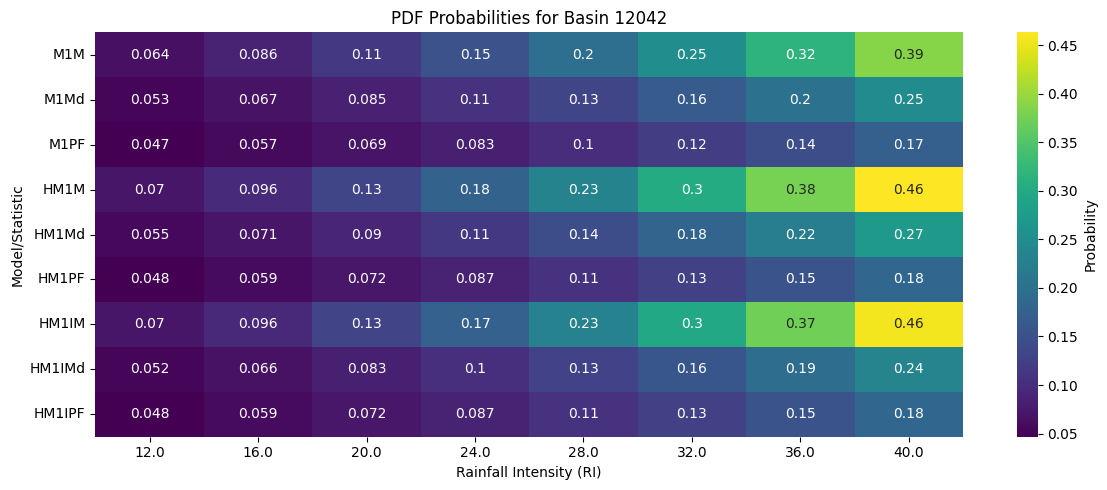

In [66]:
# Filter to a single basin (e.g., Basin 12042)
basin_id = 12042
basin_data = df[df['BASIN_ID'] == basin_id]

# Reshape for heatmap: rows = model/stat, cols = RI
heatmap_data = basin_data.set_index('RI')[
    ['M1M', 'M1Md', 'M1PF', 'HM1M', 'HM1Md', 'HM1PF', 'HM1IM', 'HM1IMd', 'HM1IPF']
].T

# Plot
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'label': 'Probability'})
plt.title(f'PDF Probabilities for Basin {basin_id}')
plt.xlabel('Rainfall Intensity (RI)')
plt.ylabel('Model/Statistic')
plt.tight_layout()
plt.show()

In [98]:
# 3x1 figure for each basin 
MvH_out = r'/Volumes/PhD/imagery/masters/output/hyper_compare/MvH_fig/'
# Create a directory for the basin if it doesn't exist
if not os.path.exists(MvH_out):
    os.makedirs(MvH_out)

unique_basins = df['BASIN_ID'].unique()
for basin in unique_basins:
    basin_data = df[df['BASIN_ID'] == basin]
    fig, axs = plt.subplots(3, 1, figsize=(8, 16), sharey=True)
    plt.suptitle(f'Basin {basin} MvH', fontsize=16, weight='bold')
    sns.lineplot(x = basin_data['RI'], y = basin_data['M1M'], ax = axs[0], c = 'b', label = 'Mean')
    sns.lineplot(x = basin_data['RI'], y = basin_data['M1Md'], ax = axs[0], c = 'm', linestyle = '--', label = 'Md')
    sns.lineplot(x = basin_data['RI'], y = basin_data['M1PF'], ax = axs[0], c = 'orange', linestyle = 'dashdot', label = 'PF')
    axs[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    axs[0].set_ylim(0,1)
    axs[0].set_ylabel('PFDF Probability')
    axs[0].set_xlabel('Rainfall Intensity')
    axs[0].legend(title = 'M1 Model', loc='upper left')

    sns.lineplot(x = basin_data['RI'], y = basin_data['HM1M'], ax = axs[1], c = 'b', label = 'Mean')
    sns.lineplot(x = basin_data['RI'], y = basin_data['HM1Md'], ax = axs[1], c = 'm', linestyle = '--', label = 'Md')
    sns.lineplot(x = basin_data['RI'], y = basin_data['HM1PF'], ax = axs[1], c = 'orange', linestyle = 'dashdot', label = 'PF')
    axs[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    axs[1].set_ylim(0,1)
    axs[1].set_ylabel('PFDF Probability')
    axs[1].set_xlabel('Rainfall Intensity')
    axs[1].legend(title = 'HM1 Model', loc='upper left')

    sns.lineplot(x = basin_data['RI'], y = basin_data['HM1IM'], ax = axs[2], c = 'b', label = 'Mean')
    sns.lineplot(x = basin_data['RI'], y = basin_data['HM1IMd'], ax = axs[2], c = 'm', linestyle = '--', label = 'Md')
    sns.lineplot(x = basin_data['RI'], y = basin_data['HM1IPF'], ax = axs[2], c = 'orange', linestyle = 'dashdot', label = 'PF')
    axs[2].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    axs[2].set_ylim(0,1)
    axs[2].set_ylabel('PFDF Probability')
    axs[2].set_xlabel('Rainfall Intensity')
    axs[2].legend(title = 'HM1I Model', loc='upper left')
    plt.tight_layout()
    #plt.savefig(os.path.join(MvH_out, f'{basin}_MvH.svg'), bbox_inches='tight')
    plt.savefig(os.path.join(MvH_out, f'{basin}_MvH.png'), bbox_inches='tight')
    plt.close()
    
    